In [1]:
import pandas as pd

# -*- coding: utf-8 -*-
"""
@name: Week 3 Poisson GLM.py
@author: Ming-Long Lam, Ph.D.
@organization: University of Chicago
"""
import matplotlib.pyplot as plt
import np as np
import pandas
import sys
# Set some options for printing all the columns
np.set_printoptions(precision = 10, threshold = sys.maxsize)
np.set_printoptions(linewidth = np.inf)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.expand_frame_repr', False)
pandas.set_option('max_colwidth', None)
pandas.options.display.float_format = '{:,.10}'.format
import seaborn as sns
import math
from scipy.stats import chi2

sys.path.append('C:\\MScAnalytics\\Linear and Nonlinear Model\\Job')
import Regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
target = 'CLM_AMT'
exposure = 'EXPOSURE'
cat_cols = ["CAR_TYPE", "CAR_USE", "EDUCATION", "GENDER", "MSTATUS", "PARENT1","RED_CAR","REVOKED","URBANICITY"]
int_pred = ["CAR_TYPE", "CAR_USE", "EDUCATION", "GENDER", "MSTATUS", "PARENT1", "RED_CAR", "REVOKED", "URBANICITY",'HOMEKIDS', 'KIDSDRIV', "AGE", "BLUEBOOK", "CAR_AGE", "HOME_VAL", "INCOME", "YOJ", "MVR_PTS", "TIF","TRAVTIME"]
claim_history = pd.read_excel('claim_history.xlsx')
claim_history[["BLUEBOOK", "HOME_VAL", "INCOME"]] = claim_history[["BLUEBOOK", "HOME_VAL", "INCOME"]] / 1000

In [3]:
train_data = claim_history[[target, exposure] + int_pred]
train_data = train_data[train_data[exposure] > 0.0].dropna().reset_index(drop = True)
y_train = train_data[target]
o_train = np.log(train_data[exposure])
train_data.head()

,CLM_AMT,EXPOSURE,CAR_TYPE,CAR_USE,EDUCATION,GENDER,MSTATUS,PARENT1,RED_CAR,REVOKED,URBANICITY,HOMEKIDS,KIDSDRIV,AGE,BLUEBOOK,CAR_AGE,HOME_VAL,INCOME,YOJ,MVR_PTS,TIF,TRAVTIME
0,0,1.0,Minivan,Commercial,High School,M,No,No,yes,No,Highly Urban/ Urban,0,0,43.0,14.94,1.0,257.0,91.0,11.0,0,1,22
1,0,0.828,SUV,Private,High School,F,Yes,No,no,No,Highly Urban/ Urban,1,0,35.0,4.01,10.0,124.0,16.0,10.0,3,4,5
2,0,1.0,Minivan,Private,Masters,F,Yes,No,no,No,Highly Rural/ Rural,0,0,43.0,22.42,1.0,210.0,53.0,5.0,0,7,36
3,0,1.0,Van,Commercial,Bachelors,M,Yes,No,yes,Yes,Highly Urban/ Urban,0,0,55.0,17.6,9.0,180.0,59.0,11.0,3,7,25
4,2920,1.0,SUV,Private,Below High Sc,F,Yes,No,no,No,Highly Urban/ Urban,0,0,45.0,6.0,5.0,107.0,0.0,0.0,3,1,48


c:\Users\yomaa\Documents\Github\University-of-Chicago\Environment\uchicago_venv\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


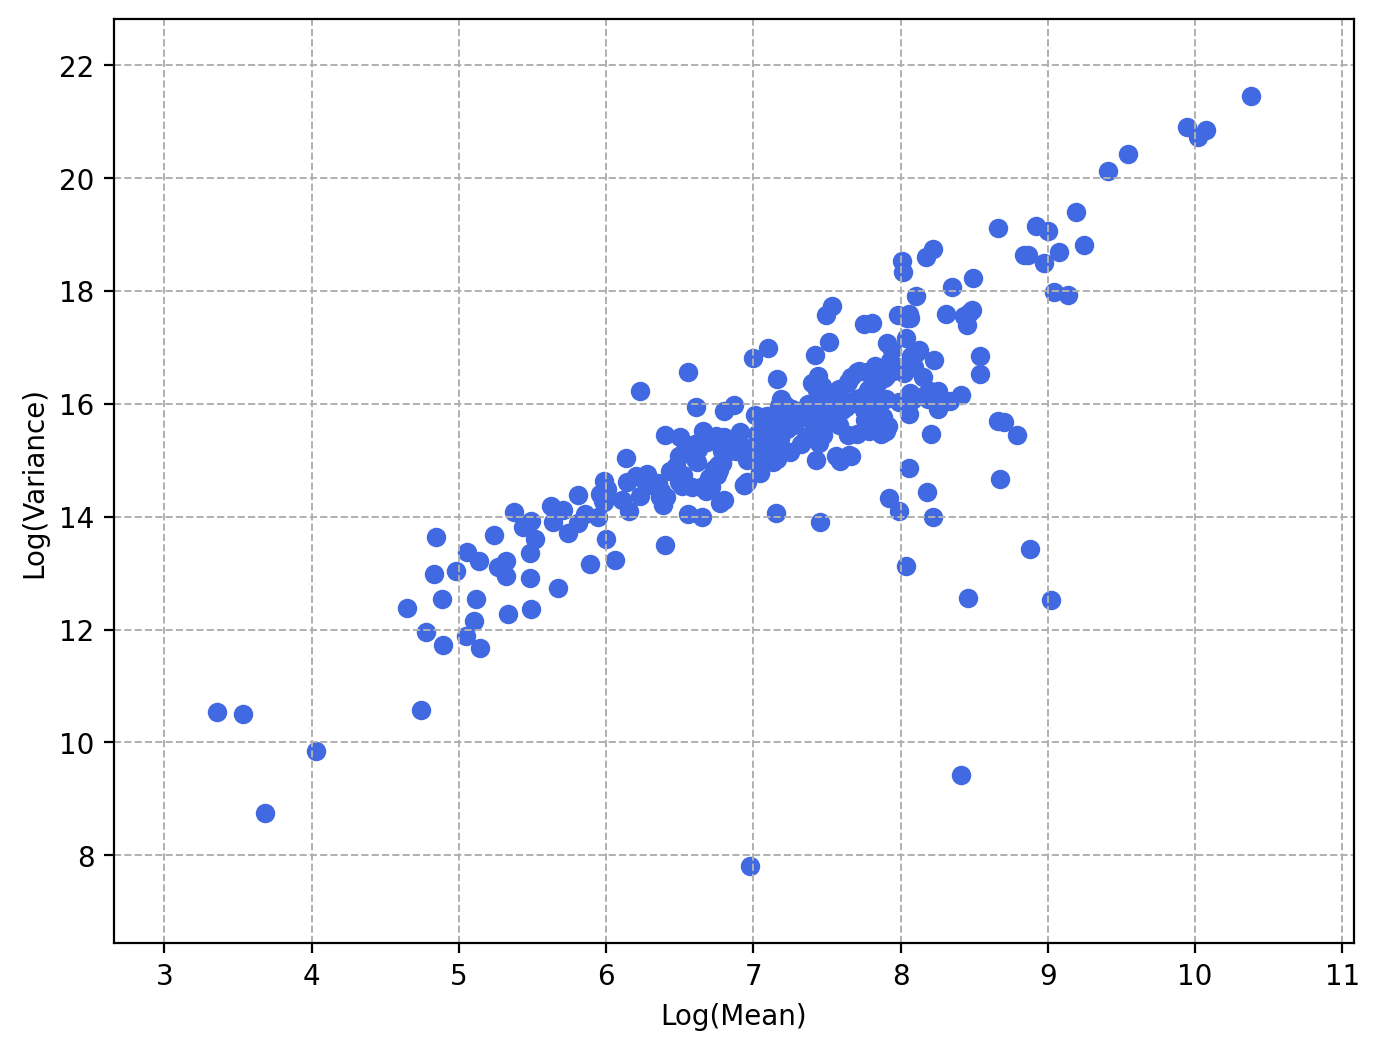

1.284060880223473 495.39032035264296


In [4]:
# Estimate the Tweedie's P value
xtab = pd.pivot_table(train_data, values = target, index = cat_cols,columns = None, aggfunc = ['count', 'mean', 'var'])
cell_stats = xtab[['mean','var']].reset_index().droplevel(1, axis = 1)
ln_Mean = np.where(cell_stats['mean'] > 1e-16, np.log(cell_stats['mean']), np.NaN)
ln_Variance = np.where(cell_stats['var'] > 1e-16, np.log(cell_stats['var']), np.NaN)
use_cell = np.logical_not(np.logical_or(np.isnan(ln_Mean), np.isnan(ln_Variance)))
X_train = ln_Mean[use_cell]
y_train = ln_Variance[use_cell]
# Scatterplot of lnVariance vs lnMean
plt.figure(figsize = (8,6), dpi = 200)
plt.scatter(X_train, y_train, c = 'royalblue')
plt.xlabel('Log(Mean)')
plt.ylabel('Log(Variance)')
plt.margins(0.1)
plt.grid(axis = 'both', linewidth = 0.7, linestyle = 'dashed')
plt.show()
X_train = pandas.DataFrame(X_train, columns = ['ln_Mean'])
X_train.insert(0, 'Intercept', 1.0)
y_train = pandas.Series(y_train, name = 'ln_Variance')
result_list = Regression.LinearRegression (X_train, y_train)
tweediePower = result_list[0][1]
tweediePhi = np.exp(result_list[0][0])
print(tweediePower,tweediePhi)

In [5]:
def create_categorical_value(dfs, column_name):
    u = dfs[column_name].astype('category')
    u_freq = u.value_counts(ascending=True)
    pm = u.cat.reorder_categories(list(u_freq.index))
    term_df_type = pandas.get_dummies(pm)
    term_df_type = term_df_type.add_suffix("_"+column_name)
    return term_df_type

In [11]:
def run_against_all(dfs, init_cols, categorical_cols, previous_train, output_train,offset_train, qll, dv):
    step_detail = []
    output_list = []
    for i in init_cols:
        if i in categorical_cols:
            new_train = previous_train.join(create_categorical_value(dfs, i), rsuffix=i)
        else:
            new_train = previous_train.join(dfs[i], rsuffix=i)
        regression_output = Regression.TweedieRegression(new_train, output_train,offset = offset_train, tweedieP = tweediePower)
        qll_1 = regression_output[3]
        dv_1 = len(regression_output[4])
        phi = regression_output[7]
        dev_chisq = 2 * (qll_1 - qll) / phi
        deviance_df = dv_1 - dv
        dev_sig = chi2.sf(dev_chisq, deviance_df)
        step_detail.append([str(i), dv_1, qll_1,dev_chisq, deviance_df, dev_sig])
        output_list.append(regression_output)
    step_df = pd.DataFrame(step_detail)
    chosen_value = step_df[step_df[5] == step_df[5].min()]
    chosen_output = output_list[step_df.index[step_df[5] == step_df[5].min()].tolist()[0]]
    return chosen_value.values, chosen_output

In [6]:
def forward_selector(data, target_col, init_cols, cat_columns,offset_col):
    # First Run
    target_train = data[target_col]
    intercept_train = data[[target_col]]
    init = init_cols
    intercept_train.insert(0, 'Intercept', 1.0)
    intercept_train = intercept_train.drop(columns=target_col)
    offset_train = np.log(data[offset_col])
    intercept_result = Regression.TweedieRegression(intercept_train, target_train, offset = offset_train, tweedieP=tweediePower)
    step_summary = []
    qll = intercept_result[3]
    dv = len(intercept_result[4])
    dev_sig = 0
    threshold = 0.05
    value_outputs = None
    step_summary.append(['Intercept', dv, qll, np.nan, np.nan, np.nan])
    while dev_sig < threshold:
        run, s = run_against_all(data, init, cat_columns, intercept_train, target_train,offset_train, qll, dv)
        run = run[0]
        qll = run[2]
        dv = run[1]
        dev_sig = run[5]
        if dev_sig < threshold:
            value_outputs = s
            if run[0] in cat_columns:
                intercept_train = intercept_train.join(create_categorical_value(data, run[0]), rsuffix=str(run[0]))
            else:
                intercept_train = intercept_train.join(data[run[0]], rsuffix=str(run[0]))
            init.remove(run[0])
            step_summary.append([run[0], dv, qll, run[3], run[4], run[5]])
    step_summary = pd.DataFrame(step_summary)
    return step_summary, value_outputs, intercept_result

In [12]:
int_pred = ["CAR_TYPE", "CAR_USE", "EDUCATION", "GENDER", "MSTATUS", "PARENT1", "RED_CAR", "REVOKED", "URBANICITY",
            'HOMEKIDS', 'KIDSDRIV', "AGE", "BLUEBOOK", "CAR_AGE", "HOME_VAL", "INCOME", "YOJ", "MVR_PTS", "TIF",
            "TRAVTIME"]
df, outps, train = forward_selector(train_data, target, int_pred, cat_cols,exposure)
print("###############################################################################################################")
# Question 2.1
print(df)

###############################################################################################################
             0   1              2           3   4                5
0    Intercept   1 -2,217,255.246         NaN NaN              NaN
1   URBANICITY   2  -2,118,973.99 529.9553643 1.0 2.888414784e-117
2    EDUCATION   6 -2,057,057.245 343.6780341 4.0  4.063543357e-73
3     CAR_TYPE  11 -1,999,000.277 331.3225609 5.0  1.833756934e-69
4      PARENT1  12 -1,953,492.124 265.7118449 1.0   9.76160529e-60
5      MVR_PTS  13 -1,918,087.974 210.4955209 1.0  1.070921883e-47
6     TRAVTIME  14 -1,902,663.015 92.43643098 1.0  6.952243693e-22
7      CAR_USE  15 -1,888,044.961 88.26369308 1.0  5.728531618e-21
8      REVOKED  16 -1,873,857.919 86.29464561 1.0  1.550277093e-20
9     KIDSDRIV  17 -1,860,340.573 82.80401415 1.0  9.060579105e-20
10         TIF  18 -1,848,415.928 73.50586562 1.0  1.003375478e-17
11      INCOME  19 -1,836,307.007 75.12078782 1.0  4.427797376e-18
12     MSTATUS  2

In [14]:
def distance_corr(x, y):
    # Calculate the Adjusted Distance for x
    x_new = pd.DataFrame(x)
    y_new = pd.DataFrame(y)
    x_new = x_new.dropna()
    y_new = y_new.dropna()
    x_new = x_new.fillna(0)
    i = x_new.to_np().T[0]
    n = len(i)
    distance_matrix_x = pd.DataFrame(np.abs(i[:, None] - i))
    distance_matrix_x = distance_matrix_x.sub(distance_matrix_x.mean(axis=0), axis=1)
    distance_matrix_x = distance_matrix_x.sub(distance_matrix_x.mean(axis=1), axis=0)
    emp_dist_x = distance_matrix_x.pow(2)
    emp_dist_x = emp_dist_x.values.sum() / (n ** 2)

    # Calculate the Adjusted Distance for y
    y_new = y_new.fillna(0)
    d = y_new.to_np().T[0]
    n = len(i)
    distance_matrix_y = pd.DataFrame(np.abs(d[:, None] - d))
    distance_matrix_y = distance_matrix_y.sub(distance_matrix_y.mean(axis=0), axis=1)
    distance_matrix_y = distance_matrix_y.sub(distance_matrix_y.mean(axis=1), axis=0)
    emp_dist_y = distance_matrix_y.pow(2)
    emp_dist_y = emp_dist_y.values.sum() / (n ** 2)

    # Calculate the Distance covariance
    emp_dist_xy = distance_matrix_x.mul(distance_matrix_y, axis="index")
    emp_dist_xy = emp_dist_xy.values.sum() / (n ** 2)

    # Calculate the Distance Correlation Coefficient

    if (emp_dist_x * emp_dist_y) != 0:
        distance_correlation_coeff = math.sqrt(emp_dist_xy / (math.sqrt(emp_dist_x * emp_dist_y)))
    else:
        distance_correlation_coeff = np.nan
    return distance_correlation_coeff


In [15]:
def PearsonCorrelation (x, y):
   '''Compute the Pearson correlation between two arrays x and y with the
   same number of values

   Argument:
   ---------
   x : a Pandas Series
   y : a Pandas Series
   
   Output:
   -------
   rho : Pearson correlation
   '''
   
   dev_x = x - np.mean(x)
   dev_y = y - np.mean(y)
   
   ss_xx = np.mean(dev_x * dev_x)
   ss_yy = np.mean(dev_y * dev_y)

   if (ss_xx > 0.0 and ss_yy > 0.0):
      ss_xy = np.mean(dev_x * dev_y)
      rho = (ss_xy / ss_xx) * (ss_xy / ss_yy)
      rho = np.sign(ss_xy) * np.sqrt(rho)
   else:
      rho = np.nan
      
   return (rho)

In [17]:
def find_metrics(y_actual, y_predicted):
      y_simple_residual = y_actual - y_predicted
      mse = np.mean(np.power(y_simple_residual, 2))
      rmse = np.sqrt(mse)
      rel_error = mse / np.var(y_actual, ddof = 0)
      dist_corr = distance_corr(y_actual, y_predicted)
      pearson_corr = PearsonCorrelation(y_actual, y_predicted)
      output_metric = pd.DataFrame({"RMSE": [np.round(rmse, 8)], "Relative Error": [rel_error],"Pearson Correlation": [np.round(pearson_corr, 8)],"Distance Correlation": [np.round(dist_corr, 8)]})
      return output_metric

In [18]:
y_train = train_data[target].values
y_pred = outps[6]

In [19]:
print("###############################################################################################################")
# Question 3.2
print(find_metrics(y_train, outps[6]))

###############################################################################################################
          RMSE  Relative Error  Pearson Correlation  Distance Correlation
0 4,116.064009     1.007898508           0.18768099            0.27019056


In [22]:
outps[0]

,Estimate,Standard Error,Lower 95% CI,Upper 95% CI,Exponentiated
Intercept,6.924694756,0.004042225292,6.91677214,6.932617372,"1,017.083764"
Highly Rural/ Rural_URBANICITY,-1.668162523,0.002775794192,-1.67360298,-1.662722067,0.1885932832
Highly Urban/ Urban_URBANICITY,0.0,-0.0,0.0,0.0,1.0
PhD_EDUCATION,0.1407007014,0.00352199863,0.133797711,0.1476036919,1.15108008
Below High Sc_EDUCATION,0.3422890658,0.002648467884,0.3370981642,0.3474799675,1.408167292
Masters_EDUCATION,0.001960290678,0.002544038157,-0.003025932486,0.006946513841,1.001962213
High School_EDUCATION,0.2373331635,0.002179935506,0.2330605684,0.2416057585,1.267863453
Bachelors_EDUCATION,0.0,-0.0,0.0,0.0,1.0
Panel Truck_CAR_TYPE,-0.03534738393,0.003625802114,-0.04245382549,-0.02824094237,0.9652700387
Van_CAR_TYPE,-0.05285179891,0.003365621885,-0.05944829659,-0.04625530123,0.9485205739


In [24]:
outps[7]

319.3817800404143

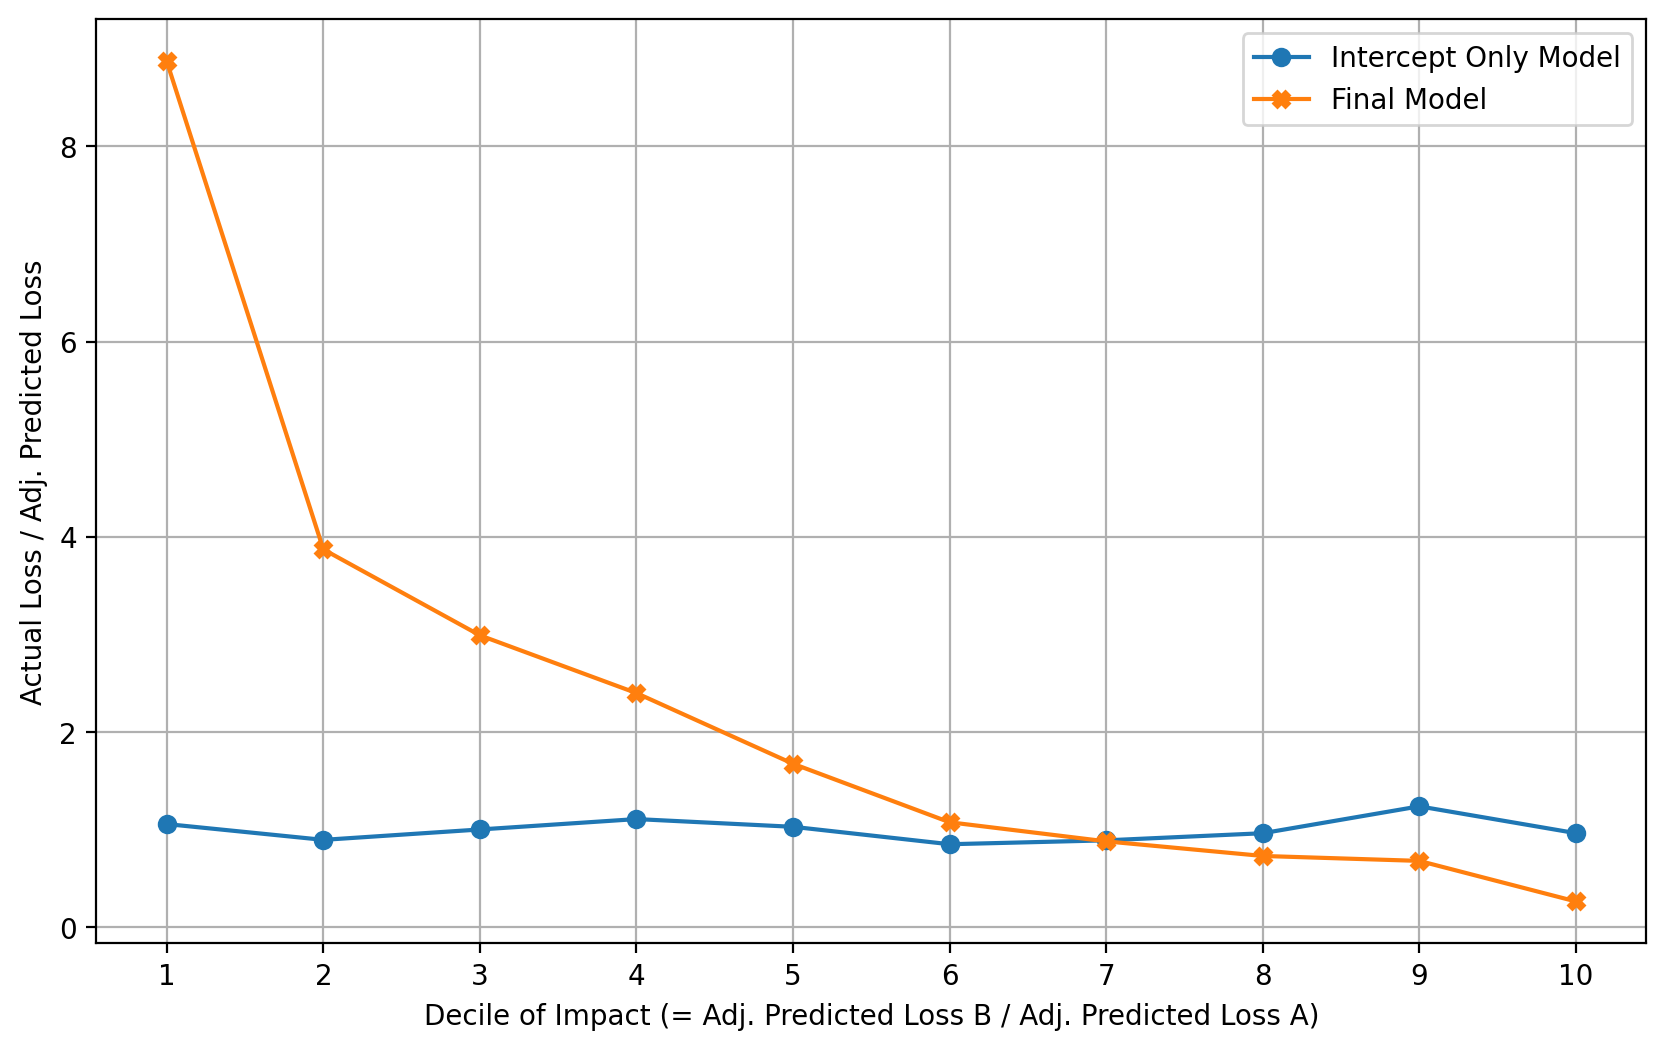

In [34]:
y_pred_A = train[6].reindex(train_data.index)
y_pred_A.name = 'Intercept Only Model'

y_pred_B = outps[6].reindex(train_data.index)
y_pred_B.name = 'Final Model'

prediction = claim_history[[target, exposure]].join(y_pred_A).join(y_pred_B).dropna()
column_sums = np.sum(prediction[['EXPOSURE', 'CLM_AMT','Intercept Only Model','Final Model']], axis = 0)

adjP_CLM_AMT_A = prediction['Intercept Only Model'] * (column_sums['CLM_AMT'] / column_sums['Intercept Only Model'])
adjP_CLM_AMT_B = prediction['Final Model'] * (column_sums['CLM_AMT'] / column_sums['Final Model'])

prediction = prediction.join(pandas.DataFrame({'AdjIntercept Only Model': adjP_CLM_AMT_A, 'AdjFinal Model': adjP_CLM_AMT_B}))
prediction['impact'] = adjP_CLM_AMT_B / adjP_CLM_AMT_A

prediction.sort_values(by = 'impact', axis = 0, ascending = True, inplace = True)
prediction['Cumulative Exposure'] = prediction['EXPOSURE'].cumsum()

cumulative_exposure_cutoff = np.arange(0.1, 1.1, 0.1) * column_sums['EXPOSURE']
decile = np.zeros_like(prediction['Cumulative Exposure'], dtype = int)
for i in range(10):
   decile = decile + np.where(prediction['Cumulative Exposure'] > cumulative_exposure_cutoff[i], 1, 0)
   
prediction['decile'] = decile + 1

xtab = pandas.pivot_table(prediction, index = 'decile', columns = None,
                          values = ['EXPOSURE','CLM_AMT','AdjIntercept Only Model', 'AdjFinal Model'],
                          aggfunc = ['sum'])

loss_ratio_A = xtab['sum','CLM_AMT'] / xtab['sum','AdjIntercept Only Model']
loss_ratio_B = xtab['sum','CLM_AMT'] / xtab['sum','AdjFinal Model']

MAE_A = np.mean(np.abs((loss_ratio_A - 1.0)))
MAE_B = np.mean(np.abs((loss_ratio_B - 1.0)))
 
plt.figure(figsize = (10,6), dpi = 200)
plt.plot(xtab.index, loss_ratio_A, marker = 'o', label = 'Intercept Only Model')
plt.plot(xtab.index, loss_ratio_B, marker = 'X', label = 'Final Model')
plt.xlabel('Decile of Impact (= Adj. Predicted Loss B / Adj. Predicted Loss A)')
plt.ylabel('Actual Loss / Adj. Predicted Loss')
plt.xticks(range(1,11))
plt.grid()
plt.legend()
plt.show()